<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/Novel_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Word2Vec Vectors from a novel in English

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
my_path="/content/drive/MyDrive/CS491/Data/"

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import re
import gensim
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords if not already downloaded and convert to set for faster access
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('he')
stop_words.discard('she')
stop_words.discard('him')
stop_words.discard('her')
stop_words.discard('his')
stop_words.discard('hers')
# stop_words=set()##do not remove stop words


# Modify the regular expression for non-alphanumeric characters removal to also remove newlines, carriage returns, and tabs
non_alpha_numeric_re = re.compile('[\n\r\t]|[^a-zA-Z0-9\s]+')

def preprocess_text(text):
    # Use the compiled regex to remove non-alphanumeric characters except for spaces, and also newlines, carriage returns, and tabs
    text = non_alpha_numeric_re.sub(' ', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords using the set for faster lookup
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Return the preprocessed text
    return ' '.join(filtered_words).strip()

def prepare_for_w2v(filename_from, filename_to, lang='english', use_sentence_tokenization=True):
    with open(filename_from, "r", encoding='utf-8') as file:
        raw_text = file.read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        # Check if sentence tokenization is used
        if use_sentence_tokenization:
            sentences = nltk.sent_tokenize(raw_text, language=lang)
        else:
            sentences = [raw_text]  # Treat the entire text as a single sentence

        for sentence in sentences:
            processed_sentence = preprocess_text(sentence.lower())
            print(processed_sentence, file=f)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, vector_size=300, window=5, min_count=1, workers=4)  # Adjusted workers to 4 for potential parallel processing improvement


In [6]:
# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
prepare_for_w2v(my_path+'The Golden Bowl', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

model = train_word2vec('train_english_text.txt')

In [7]:
import numpy as np
from scipy.spatial.distance import cosine

def calculate_distance_to_line(point, line_start, line_end):
    # Calculate the line vector
    line_vector = line_end - line_start
    # Normalize the line vector
    line_vector_norm = line_vector / np.linalg.norm(line_vector)
    # Calculate the vector from the line_start to the point
    point_vector = point - line_start
    # Project point_vector onto line_vector
    projection_length = np.dot(point_vector, line_vector_norm)
    projection = projection_length * line_vector_norm
    # Calculate the distance from the point to the projection
    distance_vector = point_vector - projection
    distance = np.linalg.norm(distance_vector)
    return distance

# Vector for "he" and "she"
he_vector = model.wv['he']
she_vector = model.wv['she']

# Calculate the line direction vector
line_direction = he_vector - she_vector

# List to store words within eps distance
words_within_eps = []

for word in model.wv.key_to_index:
    if word in ['he', 'she']:
        continue

    word_vector = model.wv[word]
    distance = calculate_distance_to_line(word_vector, she_vector, he_vector)

    # If distance is within eps, add to list
    if distance <= 2.5:
        words_within_eps.append(word)

# Output the words within eps distance
len(words_within_eps)/ len(model.wv.key_to_index)


0.020678578598674963

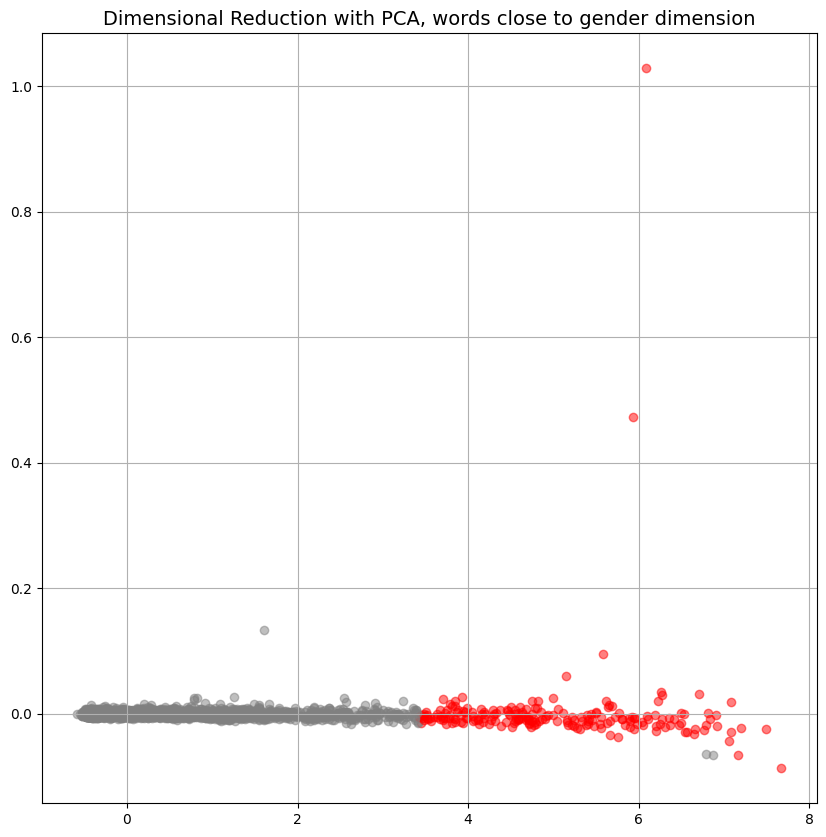

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded

# Step 2: Extract word vectors and their labels
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Step 3: Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(word_vectors)

# Step 4: Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'red' if word in words_within_eps else 'gray'
    plt.scatter(reduced_vectors_pca[i, 0], reduced_vectors_pca[i, 1], color=color, alpha=0.5)

plt.title("Dimensional Reduction with PCA, words close to gender dimension", fontsize=14)
plt.grid(True)
plt.show()



In [9]:


# Function to retrieve words within specified boundaries
def get_words_in_plot_area(x_min, x_max, y_min, y_max, vectors, words):
    selected_words = []
    for i, (x, y) in enumerate(vectors):
        if x_min <= x <= x_max and y_min <= y <= y_max:
            selected_words.append(words[i])
    return selected_words



In [10]:
# Retrieve and print the words in the specified area
words_in_area = get_words_in_plot_area(5, 8, -0.1, 0.4, reduced_vectors_pca ,words)
print(words_in_area)

['her', 'she', 'he', 'his', 'him', 'would', 'maggie', 'one', 'charlotte', 'might', 'could', 'little', 'even', 'said', 'much', 'made', 'time', 'see', 'mrs', 'know', 'well', 'way', 'quite', 'come', 'yet', 'make', 'nothing', 'like', 'still', 'say', 'prince', 'something', 'really', 'never', 'father', 'moment', 'question', 'always', 'back', 'fact', 'things', 'however', 'last', 'fanny', 'enough', 'without', 'eyes', 'almost', 'everything', 'take', 'thing', 'must', 'good', 'felt', 'oh', 'together', 'anything', 'less', 'first', 'least', 'place', 'husband', 'great', 'though', 'sense', 'thought', 'came', 'long', 'matter', 'face', 'may', 'looked', 'day', 'ever', 'life', 'far', 'rather', 'old', 'perhaps', 'taken', 'mr', 'indeed', 'present', 'man', 'effect', 'young', 'hour', 'upon', 'light', 'high']


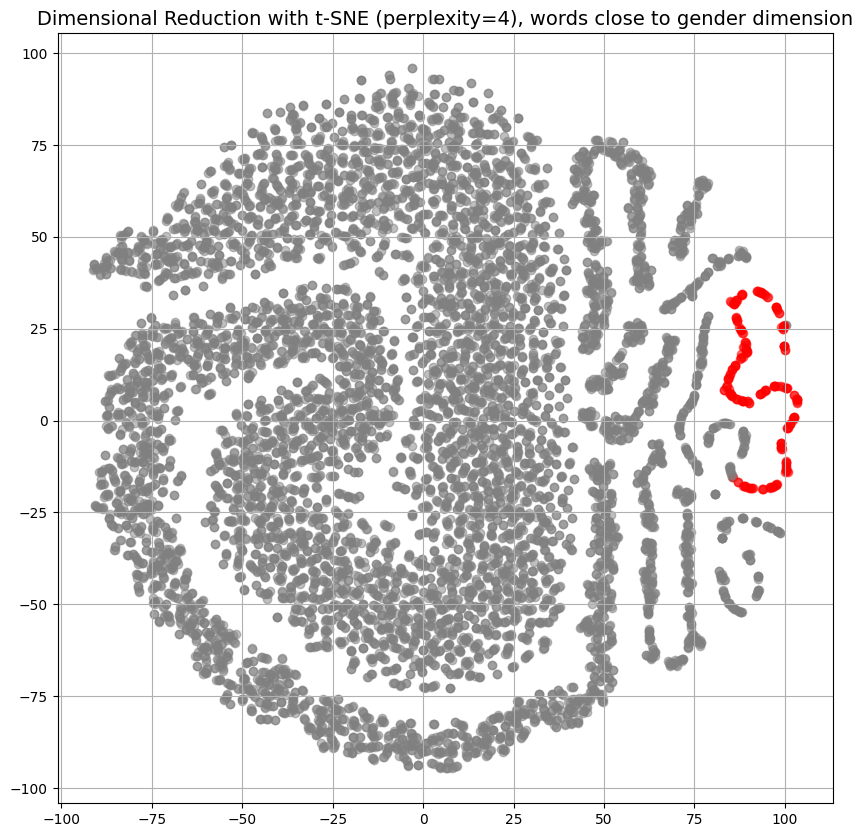

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded


words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Apply t-SNE to reduce dimensions to 2, including a perplexity parameter
# Adjust the perplexity value as needed, typical values range from 5 to 50
perplexity_value = 4  # Example value, adjust based on your data and needs
tsne = TSNE(n_components=2, perplexity=perplexity_value)
reduced_vectors_tsne = tsne.fit_transform(word_vectors)

#  Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'red' if word in words_within_eps else 'gray'
    plt.scatter(reduced_vectors_tsne[i, 0], reduced_vectors_tsne[i, 1], color=color, alpha=0.5)

plt.title(f"Dimensional Reduction with t-SNE (perplexity={perplexity_value}), words close to gender dimension", fontsize=14)
plt.grid(True)
plt.show()


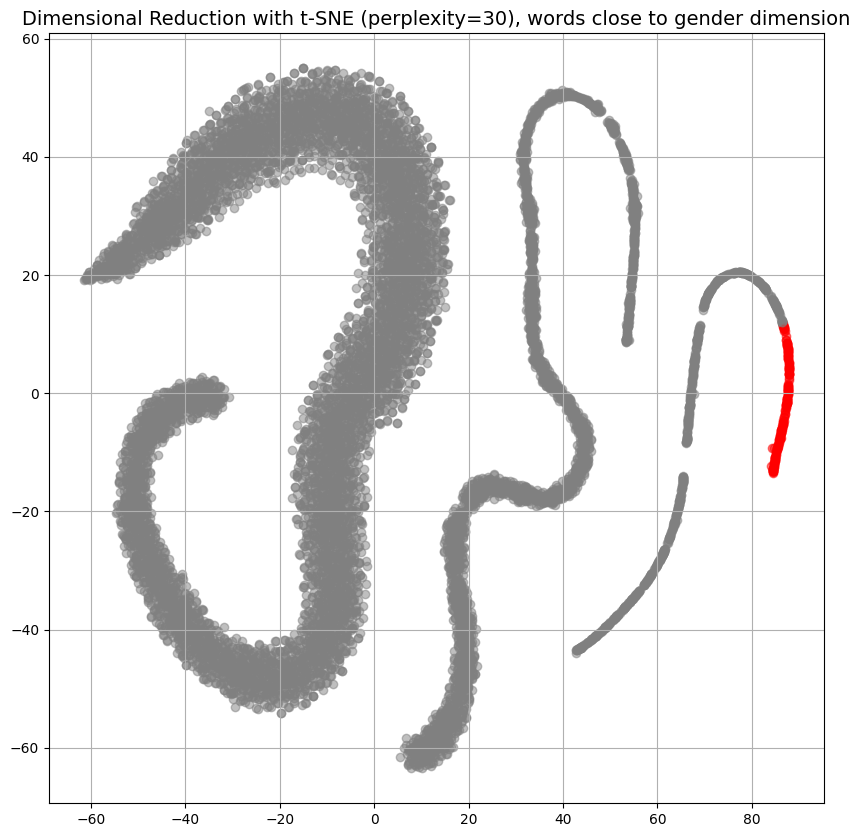

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded


words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Apply t-SNE to reduce dimensions to 2, including a perplexity parameter
# Adjust the perplexity value as needed, typical values range from 5 to 50
perplexity_value = 30  # Example value, adjust based on your data and needs
tsne = TSNE(n_components=2, perplexity=perplexity_value)
reduced_vectors_tsne = tsne.fit_transform(word_vectors)

#  Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'red' if word in words_within_eps else 'gray'
    plt.scatter(reduced_vectors_tsne[i, 0], reduced_vectors_tsne[i, 1], color=color, alpha=0.5)

plt.title(f"Dimensional Reduction with t-SNE (perplexity={perplexity_value}), words close to gender dimension", fontsize=14)
plt.grid(True)
plt.show()


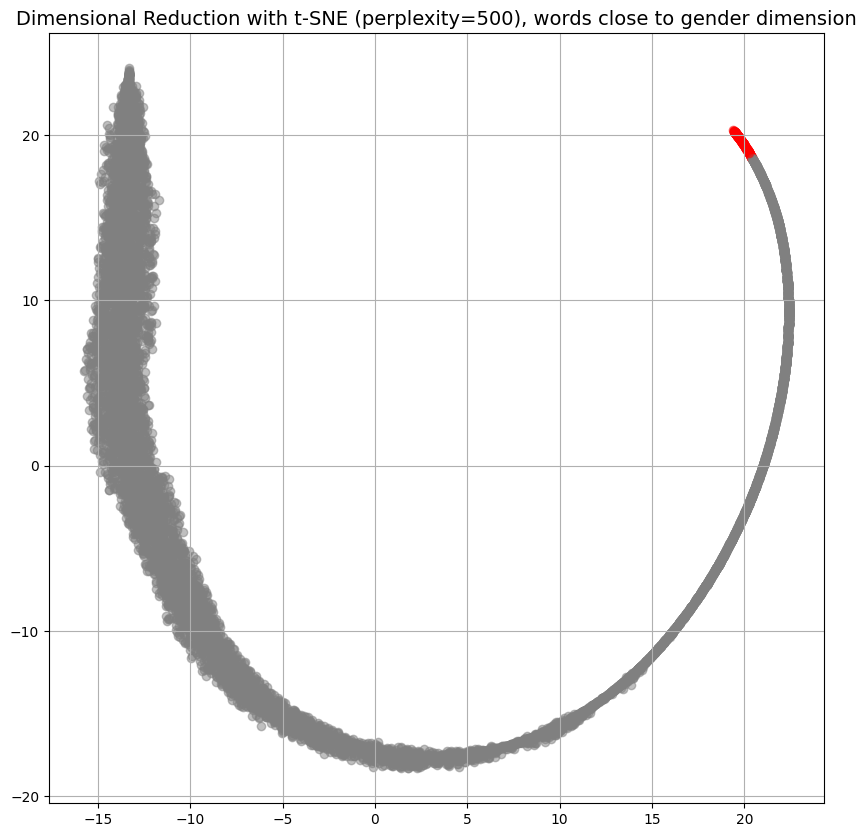

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded


words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Apply t-SNE to reduce dimensions to 2, including a perplexity parameter
# Adjust the perplexity value as needed, typical values range from 5 to 50
perplexity_value = 500  # Example value, adjust based on your data and needs
tsne = TSNE(n_components=2, perplexity=perplexity_value)
reduced_vectors_tsne = tsne.fit_transform(word_vectors)

#  Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'red' if word in words_within_eps else 'gray'
    plt.scatter(reduced_vectors_tsne[i, 0], reduced_vectors_tsne[i, 1], color=color, alpha=0.5)

plt.title(f"Dimensional Reduction with t-SNE (perplexity={perplexity_value}), words close to gender dimension", fontsize=14)
plt.grid(True)
plt.show()


In [14]:
!pip install umap-learn -q

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


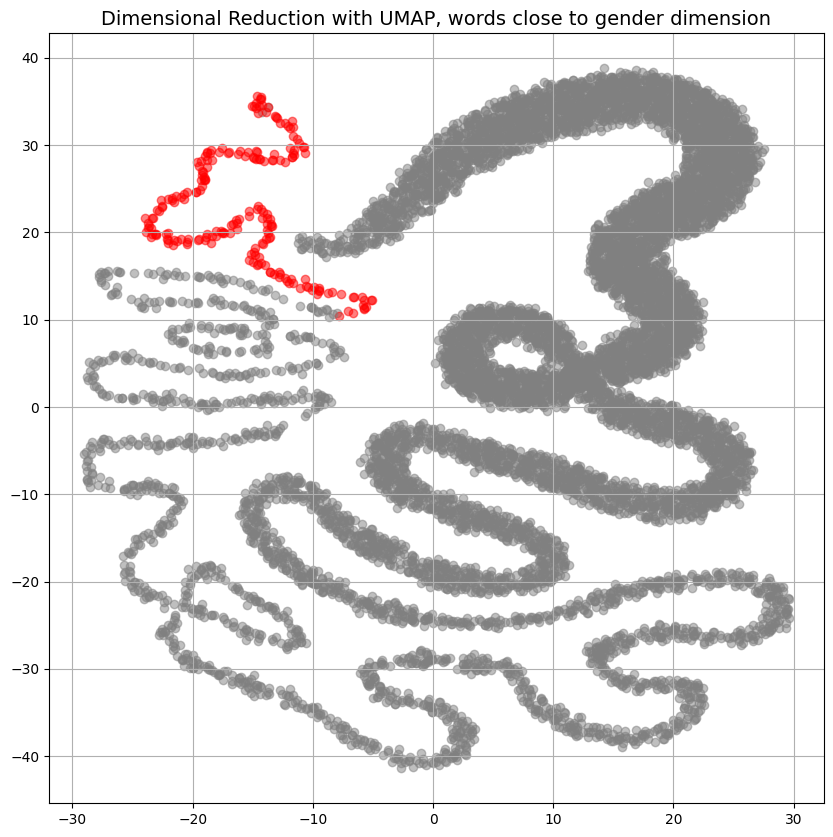

In [16]:
from umap import UMAP
import matplotlib.pyplot as plt

# Assuming your model and words_within_eps are loaded
words = list(model.wv.key_to_index.keys())  # adjust this if using an older version of gensim
word_vectors = model.wv[words]

# Apply UMAP to reduce dimensions to 2
# You can adjust n_neighbors and min_dist as needed
umap_reducer = UMAP(n_components=2, n_neighbors=15, min_dist=2.5, spread=3.0)  # Increase spread
reduced_vectors_umap = umap_reducer.fit_transform(word_vectors)

# Plot the reduced word vectors with color differentiation
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    color = 'red' if word in words_within_eps else 'gray'
    plt.scatter(reduced_vectors_umap[i, 0], reduced_vectors_umap[i, 1], color=color, alpha=0.5)

plt.title("Dimensional Reduction with UMAP, words close to gender dimension", fontsize=14)
plt.grid(True)
plt.show()